# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

D:\Program Files\Python\Python38\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55915 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:55916' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    # "images/ODT_1_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    # "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
SequenceName = "Evaporative_Cooling" + "/"
folderPath = SequenceName + get_date()

# An example for one experimental run

## Load the data

In [5]:
shotNum = "0000"
filePath = folderPath + "/" + shotNum + "/*.h5"
filepath = r"./testData/0002/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filepath, groupList[i])
    for i in range(len(groupList))
}

dataSet = dataSetDict["camera_1"]

scanAxis = get_scanAxis(dataSet)

auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

<xarray.Dataset>
Dimensions:     (runs: 3, x: 1200, y: 1920)
Coordinates:
  * runs        (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: x, y
Data variables:
    atoms       (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    background  (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    dark        (runs, x, y) uint16 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
    shotNum     (runs) int64 0 1 2
    OD          (runs, x, y) float64 dask.array<chunksize=(1, 1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    runs:                              [0. 1. 2.]
    scanAxis:                          ['runs']
    scanAxisLength:                    [3.]

## Calculate an plot OD images

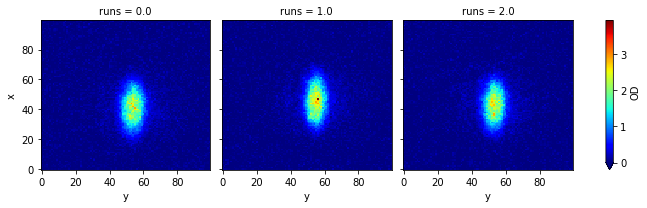

In [6]:
imageAnalyser.center = (890, 950)
imageAnalyser.span = (100,100)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Do a 2D two-peak gaussian fit to the OD images

### Do the fit

In [7]:
fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

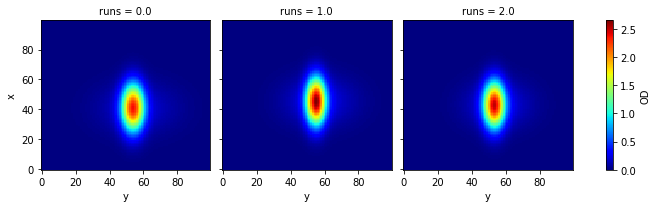

In [8]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

### Get the result of the fit

In [9]:
fitAnalyser.get_fit_value(fitResult)

<xarray.Dataset>
Dimensions:      (runs: 3)
Coordinates:
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (runs) float64 707.7 677.1 672.9
    A_centerx    (runs) float64 53.79 54.95 53.33
    A_centery    (runs) float64 41.15 45.33 42.93
    A_sigmax     (runs) float64 4.623 4.042 4.348
    A_sigmay     (runs) float64 11.14 11.08 10.93
    B_amplitude  (runs) float64 226.6 255.8 236.7
    B_centerx    (runs) float64 56.33 56.77 55.35
    B_centery    (runs) float64 40.97 45.56 43.29
    B_sigmax     (runs) float64 15.93 14.59 13.32
    B_sigmay     (runs) float64 11.67 11.32 10.98
    delta        (runs) float64 -11.31 -10.54 -8.974

In [10]:
fitAnalyser.get_fit_std(fitResult)

<xarray.Dataset>
Dimensions:      (runs: 3)
Coordinates:
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (runs) float64 7.958 7.015 9.184
    A_centerx    (runs) float64 0.02158 0.0181 0.02139
    A_centery    (runs) float64 0.06839 0.06528 0.07269
    A_sigmax     (runs) float64 0.03128 0.02593 0.03292
    A_sigmay     (runs) float64 0.06829 0.06524 0.07257
    B_amplitude  (runs) float64 9.231 8.323 9.877
    B_centerx    (runs) float64 0.4686 0.3437 0.3496
    B_centery    (runs) float64 0.4251 0.3388 0.3642
    B_sigmax     (runs) float64 0.6246 0.4683 0.4882
    B_sigmay     (runs) float64 0.4245 0.3386 0.3637
    delta        (runs) float64 0.6074 0.4543 0.4687

In [11]:
fitAnalyser.get_fit_full_result(fitResult)

<xarray.Dataset>
Dimensions:      (runs: 3)
Coordinates:
  * runs         (runs) float64 0.0 1.0 2.0
Data variables:
    A_amplitude  (runs) object 708+/-8 677+/-7 673+/-9
    A_centerx    (runs) object 53.788+/-0.022 54.955+/-0.018 53.330+/-0.021
    A_centery    (runs) object 41.15+/-0.07 45.33+/-0.07 42.93+/-0.07
    A_sigmax     (runs) object 4.623+/-0.031 4.042+/-0.026 4.348+/-0.033
    A_sigmay     (runs) object 11.14+/-0.07 11.08+/-0.07 10.93+/-0.07
    B_amplitude  (runs) object 227+/-9 256+/-8 237+/-10
    B_centerx    (runs) object 56.3+/-0.5 56.77+/-0.34 55.35+/-0.35
    B_centery    (runs) object 41.0+/-0.4 45.56+/-0.34 43.3+/-0.4
    B_sigmax     (runs) object 15.9+/-0.6 14.6+/-0.5 13.3+/-0.5
    B_sigmay     (runs) object 11.7+/-0.4 11.32+/-0.34 11.0+/-0.4
    delta        (runs) object -11.3+/-0.6 -10.5+/-0.5 -9.0+/-0.5

## Get the Ncount

### Do a 1D fit

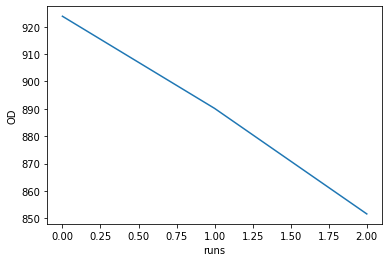

In [14]:
Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)

Ncount.plot()
plt.show()

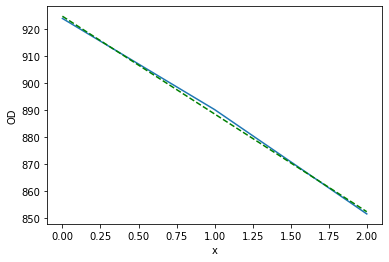

In [33]:
fitAnalyser = FitAnalyser("Linear", fitDim=1)

params = fitAnalyser.guess(Ncount, x="runs", dask="parallelized")
fitResult = fitAnalyser.fit(Ncount, params, x="runs").load()

fitCurve = fitAnalyser.eval(fitResult, x=np.arange(3), dask="parallelized").load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax)
fitCurve.plot.errorbar(ax=ax, fmt='--g')

plt.show()

### Calculate the mean and standard deviation

In [41]:
Ncount_mean = Ncount.mean(dim='runs')
Ncount_std = Ncount.std(dim='runs')